In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from user import User

import tensorflow as tf

from tensorflow import keras

from sklearn.model_selection import train_test_split

from timeit import default_timer as timer


In [2]:
def smooth_curve(points, factor=0.9):
    # from the book
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def roundwise_acc_loss(roundwise_evals):
    """
    returns a list of acc and loss per round for the user
    shape (rounds, num_users)
    """
    acc = []
    loss = []
    for r in roundwise_evals:
        t_acc = []
        t_loss = []
        for evals in r:
            t_acc.append(evals[1])
            t_loss.append(evals[0])
        acc.append(t_acc)
        loss.append(t_loss)
    return acc, loss
def print_stats(acc,loss, save_as = None):
#     https://matplotlib.org/3.1.1/gallery/statistics/boxplot_demo.html
"""
prints loss and accuracy for the user over the federations rounds 
prints a box plot of the latest accuracies and losses
"""
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    fig.suptitle(save_as)
    axs[0,0].set_title("Accuracy per round")
    axs[0,0].set_xlabel('User')
    axs[0,0].set_ylabel('Accuracy')
    axs[0,1].set_title("Loss per round")
    axs[0,1].set_xlabel('User')
    axs[0,1].set_ylabel('Loss')
    x = [ _ for _ in range(len(acc[0]))]
    for i in range(len(acc)):
        axs[0,0].plot(x, acc[i], 'b', label='acc')
        axs[0,1].plot(x, loss[i], 'r', label='loss')
#         std_dev_acc = standard_deviation(acc[i])
#         std_dev_loss = standard_deviation(loss[i])        
#         print(f"Round {i:>2} standard deviation for: \
#         \n\t{'accuracy':<8} {std_dev_acc:>.4f}\n\t{'loss':<8} {std_dev_loss:>.4f}")
    
    axs[1,0].set_title("Lastest Accuracies")
    axs[1,0].boxplot(acc[-1])
    
    axs[1,1].set_title("Lastest Losses")
    axs[1,1].boxplot(loss[-1])
    
    axs[1,1].set_ylabel('Loss')
    axs[1,0].set_ylabel('Accuracy')
    if save_as:
        plt.savefig(save_as)
    plt.show()
    plt.clf()

def standard_deviation(lst):
    avg = sum(lst)/len(lst)
    temp = 0
    for i in lst:
        temp += (i-avg)**2
    std_dev = ((1/len(lst))*(temp))**0.5
    return std_dev

In [3]:
def read_file(file):
    "return 2d df after imputing with 0s"
    
    # read data
    df = pd.read_csv(file)

    # replace the question marks with NaN and then change data type to float 32
    df.replace(["?"],np.nan, inplace = True)
    df = df.astype(np.float32)

    # imputation
    df.fillna(0,inplace=True) # fill nulls with 0
    return df 


def split_dataframe(df, user=None, val_ratio = 0.25, test_ratio =  0.75, seed = 1):
    # split into train, validation and test data using sklearn and return dfs for each
    if user!=None:
        df = df[df["User"] == user]
    if df.shape[0] == 0:
        # if no data for the user, then return 9 empty dfs as per the api
        print(f"Dataframe for user {user} is of shape {df.shape}, no data. Skipping...")
        df = pd.DataFrame()
        return (df for _ in range(9))
        
    df_train, df_test = train_test_split(df,
                                         test_size = test_ratio, 
                                         random_state = seed)

    df_train, df_val  = train_test_split(df_train, 
                                         test_size = val_ratio,
                                         random_state = seed)

    # store class and user information (in order)
    df_val_class, df_train_class, df_test_class = df_val["Class"], df_train["Class"], df_test["Class"]
    df_val_user,  df_train_user,  df_test_user  = df_val["User"],  df_train["User"],  df_test["User"]

    # drop the class and user identifier columns from data frame
    df_val   = df_val.  drop(df_train.columns[[0,1]], axis=1)
    df_train = df_train.drop(df_train.columns[[0,1]], axis=1)
    df_test  = df_test. drop(df_test. columns[[0,1]], axis=1)
    
    return df_val, df_val_class,  df_val_user, \
           df_test, df_test_class, df_test_user, \
           df_train, df_train_class, df_train_user

def draw_graphs(user, loss = True, accuracy = True):
    # this is from the book 74,75
    # history = model.fit(...)
    history = user.get_history()
    history_dict = history.history
    
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(loss_values) + 1)
    plt.xlabel('Epochs')
        
    if loss: 
        plt.plot(epochs, acc_values, 'b', label='Training acc')
        plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        plt.clf()    
    if accuracy:
        plt.plot(epochs, loss_values, 'b', label='Training loss')
        plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.clf()


In [4]:
def init_users(df, num_users):
    print("Initialising User instances...")
    users = []
    for i in range(num_users):
        df_val, df_val_class,  df_val_user, \
            df_test, df_test_class, df_test_user, \
            df_train, df_train_class, df_train_user = split_dataframe(df,user=i)

        if df_val.shape[0]==0:
            print(f"User {i} has no data, no instance created...")
            continue

        model = init_model(init_seed = 1)

        users.append(User(id=i, 
                          model = model,
                          train_class = df_train_class, 
                          train_data = df_train,
                          val_class = df_val_class, 
                          val_data = df_val,
                          test_class = df_test_class, 
                          test_data = df_test))

    print(f"{len(users)} User instaces created!")
    return users

def train_users(users, epochs, 
                new_weights = None, 
                evaluate = True, 
                verbose = True,
                epsilon = 0):
    weights = []
    for i,user in enumerate(users):
        
        if verbose:
            message = f"User {user.get_id()} being trained on the model...\n"
            print(message,end="")
        
        model, history, weight = train_model(
            user,
            epochs = epochs,
            weights = new_weights, # if none, then wont be updated
            return_weights=True,
            evaluate = evaluate
        )
        val_acc = history.history["val_acc"][-1] #get the final one
        if val_acc>=epsilon:
            weights.append(weight)
        else:
            print(f"User {user.get_id():>2} skipped. Validation Acc of {val_acc:>.4f} \
            did not match the threshold of at least {epsilon}")
        #draw_graphs(history)

        if verbose:
            message = f"User {user.get_id()} done!\n"
            print(message)
            
    return weights

In [5]:
def init_model(init_seed=1):
    model = keras.Sequential([
        keras.layers.Flatten(),
#         keras.layers.Dense(2048, activation='relu',
#                            kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(128, activation='relu',
                           kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(32, activation='relu',
                           kernel_initializer=keras.initializers.glorot_uniform(seed=init_seed)),
        keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )
    
    return model

def train_model(user, epochs=32, 
                verbose=0, return_weights = False,
                weights = None, evaluate = True):
    # https://www.tensorflow.org/beta/tutorials/keras/basic_classification
    # same seed value for consistency sake, across all trainings too
    """
    trains the model for the user 
    and updates the weights and history attribute for the user too
    """
    
    train_data = user.get_train_data()
    train_class = user.get_train_class()
    val_data = user.get_val_data()
    val_class = user.get_val_class()
    model = user.get_model()
    
    if weights != None:
        # if a weight is given, set the user's model's weight to the 
        # values that were passed in 
#         print(f"{user.get_id()}: Weights updated!")
        model.set_weights(weights)
    
    if evaluate:
        print("Pre-fit and Post-fit")
        e = evaluate_user(user)
    
    history = model.fit(
        train_data, 
        train_class, 
        epochs = epochs,
        verbose = verbose,
#         batch_size = 2**8, #4k
#         use_multiprocessing = True,
        validation_data = (val_data, val_class)
    )
        
    if evaluate:
        e = evaluate_user(user)

    # update user data 
    user.set_history(history)
    user.set_weights(weights)
    
    if return_weights:
        return model, history, model.get_weights()
    return model, history
    
def average_weights(weights):
    # weights = [ [user0] ... [list of numpy arrays of layer weights and biases]... [usern]]

    new_weights = []

    for data_index in range(len(weights[0])):
        temp_layer_data = None
        for i, user_data in enumerate(weights):
            # if data_index==0: # layer 0 weight 0 for all users
                # print(user_data[data_index][0][0])            
            if temp_layer_data is None:
                temp_layer_data = user_data[data_index]
                continue
            temp_layer_data += user_data[data_index]
              
        new_weights.append(temp_layer_data/(i+1))
        
    # print("Test final weight for layer 0 weight 0",new_weights[0][0][0])
    return new_weights


def evaluate_all_users(users, verbose = True):
    "prints the loss and accuracy for each User instance in the list users"
    e_lst = []
    for user in users:
        if verbose:
            print(f"User {user.get_id():>2}...")     
            e = evaluate_user(user, verbose)
            print(e)
        else:
            e = evaluate_user(user, verbose)
        e_lst.append(e)
    return e_lst

def evaluate_user(user, verbose = True):
    "prints the loss and accuracy for the given User instance"
    test_data = user.get_test_data()
    test_class = user.get_test_class()
    model = user.get_model()
    evaluation = model.evaluate(test_data, 
                                test_class,
                                verbose = verbose)
    return evaluation

In [6]:
df = read_file("../dataset/allUsers.lcl.csv")

# shuffle the records
df_unshuffled = df
df = df.sample(frac = 1) # shuffle data


In [7]:
def train_fed(df, epochs, rounds, users, epsilon = 0):
    
    post_evals = []
    pre_evals = []
    new_weights = None
#     with tf.device(DEVICE):

    for i in range(rounds):
        message = f"{'*'*32} {i:^4} {'*'*32}\n"
        print(message)
        pre_evals.append(evaluate_all_users(users,verbose = False))
        user_weights = train_users(users, epochs = EPOCHS,
                                   new_weights = new_weights,
                                   evaluate = False, verbose = False,
                                   epsilon = epsilon)

        new_weights = average_weights(user_weights)

        post_evals.append(evaluate_all_users(users,verbose = False))

        message = f"{'*'*32} {'DONE':^4} {'*'*32}\n"
        print(message)
    return pre_evals, post_evals


In [8]:
# config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 10} ) 
# sess = tf.Session(config=config) 
# keras.backend.set_session(sess)

DEVICE = '/cpu:0'
ROUNDS = 32
EPOCHS = 16 # 16 is good

# start = timer()

with tf.device(DEVICE):

    
    df_val, df_val_class,  df_val_user, \
        df_test, df_test_class, df_test_user, \
        df_train, df_train_class, df_train_user = split_dataframe(df)

    global_model = init_model(init_seed = 1)
    global_user = User(id=-1, 
                      model = global_model,
                      train_class = df_train_class, 
                      train_data = df_train,
                      val_class = df_val_class, 
                      val_data = df_val,
                      test_class = df_test_class, 
                      test_data = df_test)

    global_model, global_history = train_model(global_user, 
                                               epochs = EPOCHS*ROUNDS,
                                               verbose=0)

# inter = timer()
# print(f"Time taken to train global model: {inter-start}")

W1004 12:58:24.706432  4744 deprecation.py:506] From C:\Program Files\Python37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Pre-fit and Post-fit
58572/58572 [==============================] - 1s 20us/sample - loss: 0.7334 - acc: 0.9681


Initialising User instances...
Dataframe for user 3 is of shape (0, 38), no data. Skipping...
User 3 has no data, no instance created...
13 User instaces created!
********************************  0   ********************************

User  4 skipped. Validation Acc of 0.6250             did not match the threshold of at least 0.9
User  7 skipped. Validation Acc of 0.3548             did not match the threshold of at least 0.9
******************************** DONE ********************************

********************************  1   ********************************

User  4 skipped. Validation Acc of 0.5833             did not match the threshold of at least 0.9
User  7 skipped. Validation Acc of 0.3226             did not match the threshold of at least 0.9
******************************** DONE ********************************

********************************  2   ********************************

User  4 skipped. Validation Acc of 0.6250             did not match the threshold of 

******************************** DONE ********************************

********************************  24  ********************************

User  4 skipped. Validation Acc of 0.8750             did not match the threshold of at least 0.9
User  7 skipped. Validation Acc of 0.6774             did not match the threshold of at least 0.9
******************************** DONE ********************************

********************************  25  ********************************

User  4 skipped. Validation Acc of 0.8750             did not match the threshold of at least 0.9
User  7 skipped. Validation Acc of 0.7097             did not match the threshold of at least 0.9
******************************** DONE ********************************

********************************  26  ********************************

User  7 skipped. Validation Acc of 0.6452             did not match the threshold of at least 0.9
******************************** DONE ********************************

******

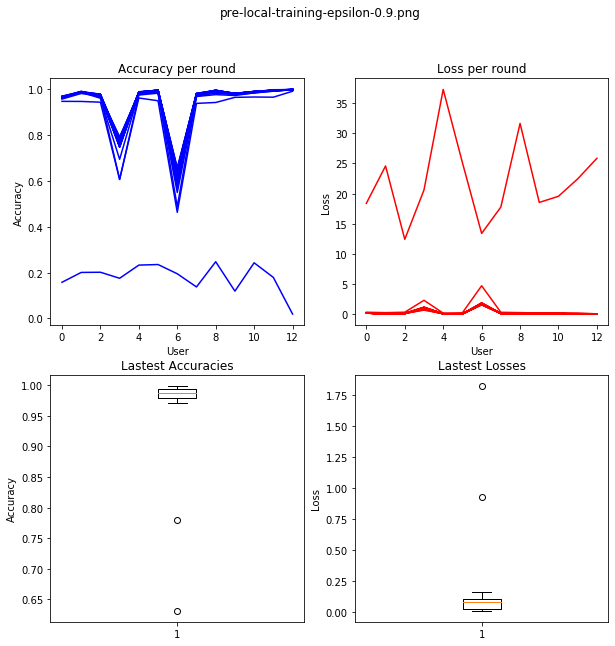

** Post local training **
Round  0 standard deviation for:         
	accuracy 0.1553
	loss     1.2753
Round  1 standard deviation for:         
	accuracy 0.1576
	loss     0.4523
Round  2 standard deviation for:         
	accuracy 0.1326
	loss     0.4503
Round  3 standard deviation for:         
	accuracy 0.1205
	loss     0.4518
Round  4 standard deviation for:         
	accuracy 0.1170
	loss     0.4287
Round  5 standard deviation for:         
	accuracy 0.1159
	loss     0.4611
Round  6 standard deviation for:         
	accuracy 0.1147
	loss     0.4858
Round  7 standard deviation for:         
	accuracy 0.1148
	loss     0.4822
Round  8 standard deviation for:         
	accuracy 0.1178
	loss     0.4977
Round  9 standard deviation for:         
	accuracy 0.1171
	loss     0.5141
Round 10 standard deviation for:         
	accuracy 0.1169
	loss     0.5053
Round 11 standard deviation for:         
	accuracy 0.1149
	loss     0.4970
Round 12 standard deviation for:         
	accuracy 0.1168
	lo

<Figure size 432x288 with 0 Axes>

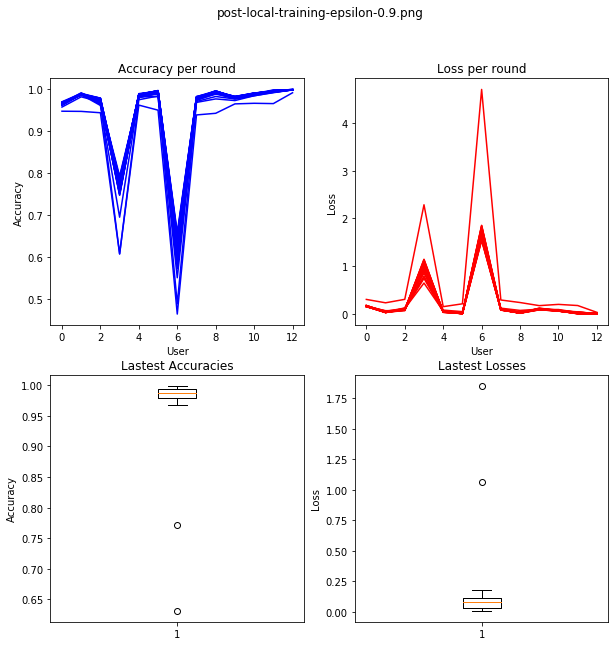

Initialising User instances...
Dataframe for user 3 is of shape (0, 38), no data. Skipping...
User 3 has no data, no instance created...
13 User instaces created!
********************************  0   ********************************

******************************** DONE ********************************

********************************  1   ********************************

******************************** DONE ********************************

********************************  2   ********************************

******************************** DONE ********************************

********************************  3   ********************************

******************************** DONE ********************************

********************************  4   ********************************

******************************** DONE ********************************

********************************  5   ********************************

******************************** DONE *******

<Figure size 432x288 with 0 Axes>

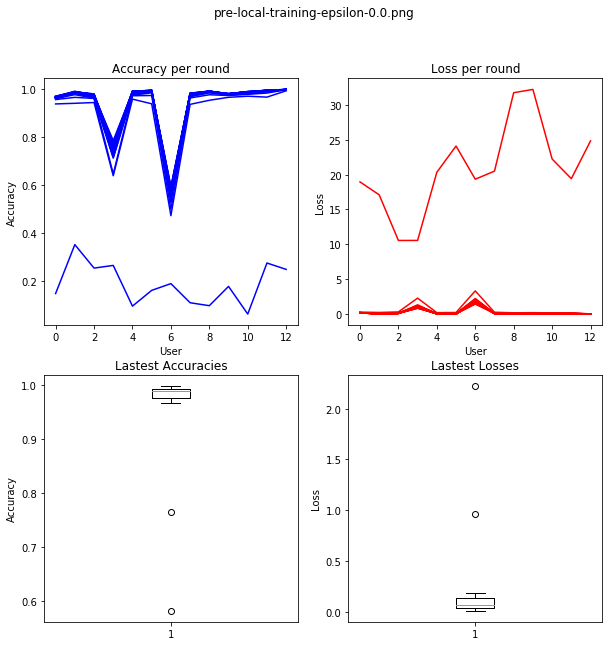

** Post local training **
Round  0 standard deviation for:         
	accuracy 0.1492
	loss     0.9619
Round  1 standard deviation for:         
	accuracy 0.1481
	loss     0.4146
Round  2 standard deviation for:         
	accuracy 0.1273
	loss     0.4276
Round  3 standard deviation for:         
	accuracy 0.1263
	loss     0.4220
Round  4 standard deviation for:         
	accuracy 0.1348
	loss     0.4484
Round  5 standard deviation for:         
	accuracy 0.1244
	loss     0.4817
Round  6 standard deviation for:         
	accuracy 0.1275
	loss     0.4948
Round  7 standard deviation for:         
	accuracy 0.1224
	loss     0.5193
Round  8 standard deviation for:         
	accuracy 0.1224
	loss     0.5378
Round  9 standard deviation for:         
	accuracy 0.1222
	loss     0.5196
Round 10 standard deviation for:         
	accuracy 0.1281
	loss     0.5394
Round 11 standard deviation for:         
	accuracy 0.1263
	loss     0.5375
Round 12 standard deviation for:         
	accuracy 0.1303
	lo

<Figure size 432x288 with 0 Axes>

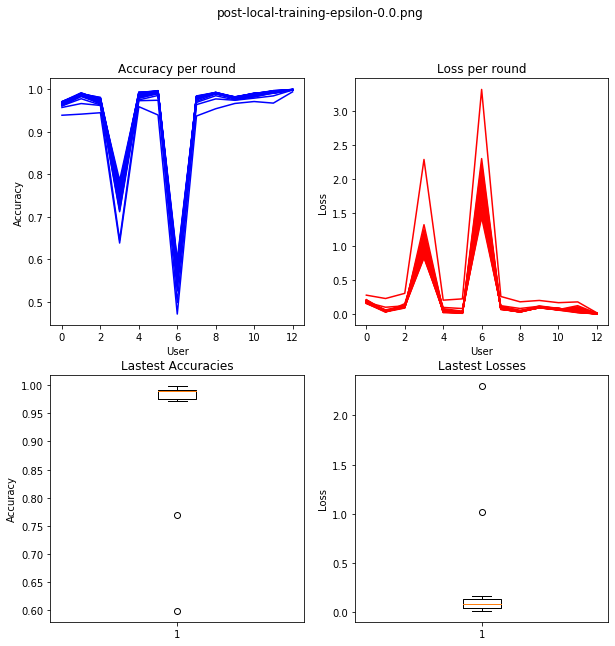

<Figure size 432x288 with 0 Axes>

In [9]:
# end = timer()
# print(f"Time taken to do the rounds: {end-inter}")
# print(f"Total time: {end-start}")
NUM_USERS = df["User"].nunique()

users = init_users(df, NUM_USERS) # return a list of users with data 

NUM_USERS=len(users)

with tf.device(DEVICE):
    pre_evals, post_evals = train_fed(df, users = users, rounds = ROUNDS,epochs = EPOCHS,
                                               epsilon = 0.9)

    pre_acc, pre_loss = roundwise_acc_loss(pre_evals)
    post_acc, post_loss  =roundwise_acc_loss(post_evals)

    print("** Pre local training **")
    print_stats(pre_acc, pre_loss, save_as="pre-local-training-epsilon-0.9.png")
    print("** Post local training **")
    print_stats(post_acc, post_loss, save_as="post-local-training-epsilon-0.9.png")

    pre_evals, post_evals = init_and_train_fed(df,rounds = ROUNDS,epochs = EPOCHS,
                                               epsilon = 0)
    pre_acc, pre_loss = roundwise_acc_loss(pre_evals)
    post_acc, post_loss  =roundwise_acc_loss(post_evals)

    print("** Pre local training **")
    print_stats(pre_acc, pre_loss, save_as="pre-local-training-epsilon-0.0.png")
    print("** Post local training **")
    print_stats(post_acc, post_loss, save_as="post-local-training-epsilon-0.0.png")


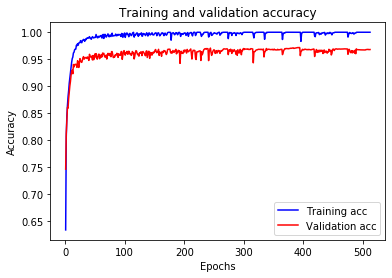

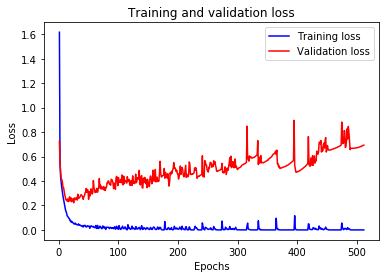

In [98]:
draw_graphs(global_user)

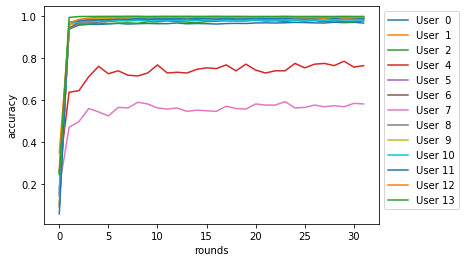

User:  0 average: 0.9395029135048389
User:  1 average: 0.9661178756505251
User:  2 average: 0.9501846311613917
User:  4 average: 0.7266447376459837
User:  5 average: 0.9571444885805249
User:  6 average: 0.9651899919845164
User:  7 average: 0.5495426822453737
User:  8 average: 0.9510789772029966
User:  9 average: 0.9615327417850494
User: 10 average: 0.9543523723259568
User: 11 average: 0.9583660647040233
User: 12 average: 0.9705484434962273
User: 13 average: 0.9755244022235274


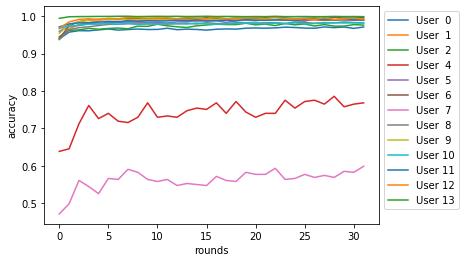

User:  0 average: 0.9653059188276529
User:  1 average: 0.9861150495707989
User:  2 average: 0.9728120304644108
User:  4 average: 0.7424342110753059
User:  5 average: 0.9852686729282141
User:  6 average: 0.9913760256022215
User:  7 average: 0.5624153111129999
User:  8 average: 0.9784204326570034
User:  9 average: 0.9895089324563742
User: 10 average: 0.9795525819063187
User: 11 average: 0.9874245338141918
User: 12 average: 0.9930117893964052
User: 13 average: 0.9990322198718786


[0.9653059188276529,
 0.9861150495707989,
 0.9728120304644108,
 0.7424342110753059,
 0.9852686729282141,
 0.9913760256022215,
 0.5624153111129999,
 0.9784204326570034,
 0.9895089324563742,
 0.9795525819063187,
 0.9874245338141918,
 0.9930117893964052,
 0.9990322198718786]

<Figure size 432x288 with 0 Axes>

In [108]:
def plot_roundwise_user(roundwise_data):
    roundwise_user_data = []
    x_axis = [i for i in range(len(roundwise_data))]
    user_no = 0
    for i in range(len(roundwise_data[0])):
        user_round_data = []
        for user_data in roundwise_data:
            user_round_data.append(user_data[i]) #user's value for the round

        roundwise_user_data.append(user_round_data)
        plt.plot(x_axis,user_round_data,label=f"User {user_no:>2}")
        if i == 2: # beacuse user 3 has no data
            user_no +=1
        user_no +=1
    plt.xlabel("rounds")
    plt.ylabel("accuracy")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
    plt.clf()
    return roundwise_user_data
def average_roundwise_user(roundwise_user_data):
    lst = []
    user_no = 0
    for i,user_round_data in enumerate(roundwise_user_data):
        avg = sum(user_round_data)/len(user_round_data)
        print(f"User: {user_no:>2} average: {avg}")
        if i == 2: # beacuse user 3 has no data
            user_no +=1
        user_no +=1  
        lst.append(avg)
    return lst
roundwise_user_pre_acc = plot_roundwise_user(pre_acc)
average_roundwise_user(roundwise_user_pre_acc)
roundwise_user_post_acc = plot_roundwise_user(post_acc)
average_roundwise_user(roundwise_user_post_acc)



            

In [ ]:

specific_user = users[1]

print(f"Evaluate for user {specific_user.get_id()} on global and local model")
global_model.evaluate(specific_user.get_test_data(), specific_user.get_test_class())
specific_user.get_model().evaluate(specific_user.get_test_data(), specific_user.get_test_class())
# draw_graphs(specific_user.get_history())